# Topic modelling of Bundestag speeches

Dataset from https://opendiscourse.de/

> Richter, F.; Koch, P.; Franke, O.; Kraus, J.; Kuruc, F.; Thiem, A.; Högerl, J.; Heine, S.; Schöps, K. (2020). Open Discourse. https://doi.org/10.7910/DVN/FIKIBO. Harvard Dataverse. V3.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pyarrow.feather as feather

In [3]:
plt.rcParams['figure.figsize'] = (14,5)

## Load Data

*Data in feather format https://arrow.apache.org/docs/python/feather.html*

In [4]:
speeches_df = feather.read_feather('data/opendiscourse/feather/speeches.feather')
fractions_df = feather.read_feather('data/opendiscourse/feather/factions.feather')
#contributions_df = feather.read_feather('data/opendiscourse/feather/contributions_extended.feather')

## Prepare Data

In [5]:
fractions_df.replace(to_replace='not found', value=np.nan, inplace=True)
fractions_df.rename(columns={'abbreviation':'fraction', 'fullName':'fractionFullName'}, inplace=True)

In [6]:
fractions_df.head()

,id,fraction,fractionFullName
0,-1,NaN,NaN
1,0,AfD,Alternative für Deutschland
2,1,BHE,Block der Heimatvertriebenen und Entrechteten
3,2,BP,Bayernpartei
4,3,Grüne,Bündnis 90/Die Grünen


In [7]:
speeches_df['speechLength'] = speeches_df['speechContent'].str.strip().str.len()
speeches_df = speeches_df.merge(fractions_df, left_on='factionId', right_on='id', how='left', suffixes=('_speech','_fraction'))

In [8]:
#speeches_df.head()

Get rid of conribution (Zwischenrufe) symbols like `({1})`

In [9]:
print('...', speeches_df.iloc[-1]['speechContent'][:1000].strip(), '...')

... Vielen Dank. – Frau Präsidentin! Liebe Kolleginnen und Kollegen! Meine Damen und Herren! Bereits im Januar 2021 hatten wir eine Aktuelle Stunde zu genau dem gleichen Thema. Damals ging es um Trump und die Sperrung seines Facebook-Accounts. Heute sollen wir hier im Parlament Kulisse für die Spitzenkandidatur von Frau Cotar für die bevorstehende Bundestagswahl sein. Das ist also alles sehr durchschaubar.

({0})

Regelmäßig versucht die AfD mit untauglichen Argumenten, die Meinungsfreiheit in unserem Land zu diskreditieren; das erleben wir auch wieder in dieser Aktuellen Stunde. Lassen Sie mich als letzten Redner in dieser Debatte die schlimmsten Falschaussagen hier kurz richtigstellen.

Frau Cotar, von Ihnen kam der erste Redebeitrag. Sie sprachen von „Meinungsdiktatur 2021“. Völliger Blödsinn!

({1})

Die Meinungsdiktatur von rechts haben wir 1945 beendet – ich erinnere an den morgigen Tag der Befreiung, den die AfD natürlich bezeichnenderweise nicht begeht –, und die Meinungsdiktat

In [10]:
speeches_df['speechContentInclContributions'] = speeches_df['speechContent']
speeches_df['speechContent'] = speeches_df['speechContent'].str.replace(pat=r"\(\s*\{\s*\d*\s*\}\s*\)", repl='', regex=True)

In [11]:
speeches_df.head()

,id_speech,session,electoralTerm,firstName,lastName,politicianId,speechContent,factionId,documentUrl,positionShort,positionLong,date,speechLength,id_fraction,fraction,fractionFullName,speechContentInclContributions
0,0,2,1,,Köhler,11001150,Meine Damen und Herren! Ich eröffne die 2. Sit...,-1,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,Presidium of Parliament,präsident,1949-09-12,546,-1,NaN,NaN,Meine Damen und Herren! Ich eröffne die 2. Sit...
1,1,2,1,,Arnold,-1,"Der Bundesrat ist versammelt, Herr Präsident.\n",-1,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,Guest,präsident des bundesrats,1949-09-12,45,-1,NaN,NaN,"Der Bundesrat ist versammelt, Herr Präsident.\n"
2,2,2,1,,Köhler,11001150,Ich danke für diese Erklärung. Ich stelle dami...,-1,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,Presidium of Parliament,präsident,1949-09-12,901,-1,NaN,NaN,Ich danke für diese Erklärung. Ich stelle dami...
3,3,2,1,,Heuss,-1,"Ja, ich habe den Wunsch.\n",-1,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,Guest,bundespräsident,1949-09-12,24,-1,NaN,NaN,"Ja, ich habe den Wunsch.\n"
4,4,2,1,,Köhler,11001150,Ich erteile dem Herrn Bundespräsidenten das Wo...,-1,https://dip21.bundestag.de/dip21/btp/01/01002.pdf,Presidium of Parliament,präsident,1949-09-12,49,-1,NaN,NaN,Ich erteile dem Herrn Bundespräsidenten das Wo...


## Basic Exploration

In [12]:
speeches_df.shape

(907644, 17)

<AxesSubplot:title={'center':'Mass of text'}, ylabel='fraction'>

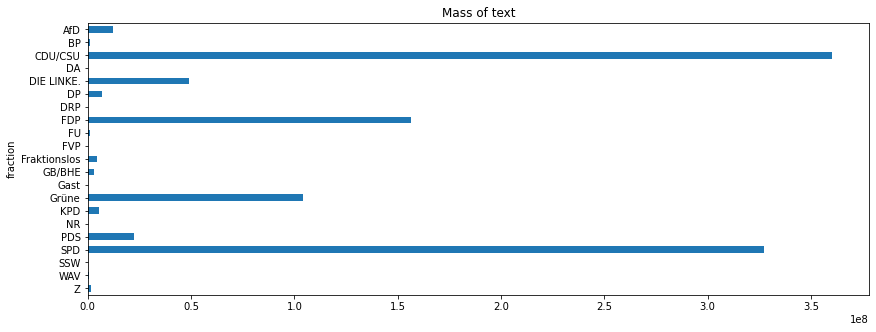

In [13]:
speeches_df[['fraction', 'speechLength']].groupby('fraction').sum().sort_index(ascending=False).plot.barh(title="Mass of text", legend=False)

Text(0.5, 0, 'Nth speech')

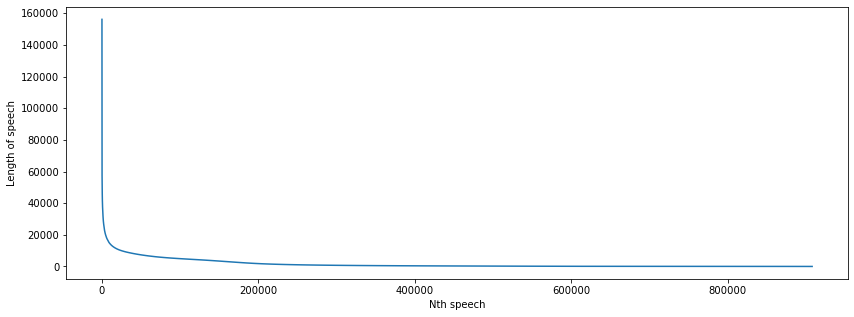

In [14]:
fig, ax = plt.subplots(figsize=(14,5))
speeches_df['speechLength'].sort_values(ascending=False).reset_index()['speechLength'][:].plot.line(ax=ax)
ax.set_ylabel('Length of speech')
ax.set_xlabel('Nth speech')